<a href="https://colab.research.google.com/github/LokiAndere/After_MIARFID/blob/main/pokemon_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#http://dm0mb.com/static/data_set/vishalsubbiah/pokemon-images-and-types/ipynb_storge/generating-new-pokemon-gans.html
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb
#https://www.youtube.com/watch?v=Nrsy6vF7rSw&ab_channel=JeffHeaton
#https://www.researchgate.net/publication/344244802_Applications_of_Deep_Neural_Networks/fulltext/5f60304b299bf1d43c04e77a/Applications-of-Deep-Neural-Networks.pdf
#https://neptune.ai/blog/google-colab-dealing-with-files

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [6]:
# human readable time period
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [11]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 1 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
#DATA_PATH = '/kaggle/input/pokemon-images-and-types/images'
DATA_PATH = '/content/drive/MyDrive/miarfid/data/'
EPOCHS = 10
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 32px square images.


In [13]:
print("Loading training images...")
start = time.time()

training_data = []
#faces_path = os.path.join(DATA_PATH,'images')
faces_path = os.path.join(DATA_PATH,'validation/human')
for filename in tqdm(os.listdir(faces_path)):
    path = os.path.join(faces_path,filename)
    image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS).convert('RGBA')
    image.load() # required for png.split()
    background = Image.new("RGBA", image.size, (255, 255, 255))
    image = Image.alpha_composite(background, image).convert('RGB')
    training_data.append(np.asarray(image))
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 127.5 - 1.

elapsed = time.time()-start
print (f'Image preprocess time: {hms_string(elapsed)}')


  0%|          | 0/56 [00:00<?, ?it/s]

Loading training images...



100%|██████████| 56/56 [00:18<00:00,  3.02it/s]

Image preprocess time: 0:00:18.57


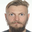

In [14]:
# example training image
image

In [15]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
        model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [18]:
def save_images(noise):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
            image_count += 1

    im = Image.fromarray(image_array)
    return im

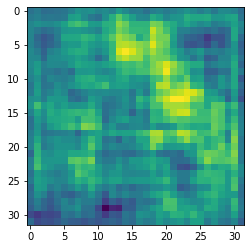

In [19]:
# test first stage generatior
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

In [20]:
# test first stage discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50005174]], shape=(1, 1), dtype=float32)


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-6,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(5.0e-6,0.5)

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [24]:
def train(dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
    start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}: gen_loss={g_loss}, disc_loss={d_loss}, {hms_string(epoch_elapsed)}')
        if np.floor((epoch+1)/10)==(epoch+1)/10:
            sample = save_images(fixed_seed)

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')
    return sample

Epoch 1: gen_loss=0.8117057085037231, disc_loss=1.634850263595581, 0:00:03.27
Epoch 2: gen_loss=0.9202172756195068, disc_loss=1.510373592376709, 0:00:00.03
Epoch 3: gen_loss=0.9585912227630615, disc_loss=1.3899431228637695, 0:00:00.03
Epoch 4: gen_loss=1.0188288688659668, disc_loss=1.402644395828247, 0:00:00.03
Epoch 5: gen_loss=0.9184250831604004, disc_loss=1.4311013221740723, 0:00:00.03
Epoch 6: gen_loss=1.0150580406188965, disc_loss=1.2296826839447021, 0:00:00.03
Epoch 7: gen_loss=0.8618148565292358, disc_loss=1.3222131729125977, 0:00:00.03
Epoch 8: gen_loss=0.9673186540603638, disc_loss=1.1570045948028564, 0:00:00.03
Epoch 9: gen_loss=1.0695480108261108, disc_loss=1.0895417928695679, 0:00:00.03
Epoch 10: gen_loss=1.0684452056884766, disc_loss=1.2124358415603638, 0:00:00.03
Training time: 0:00:03.96


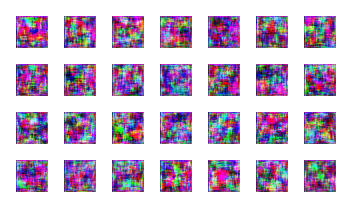

In [25]:
# sample of generations
sample = train(train_dataset, EPOCHS)
sample